<a href="https://colab.research.google.com/github/maxsanchezdp/music_classifier/blob/master/Copia_de_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
#import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict


from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16

import tqdm as tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [ ]:

"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [ ]:

def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [ ]:
# Parameters
gtzan_dir = '/content/drive/My Drive/final_project_dataset/genres/'
song_samples = 660000
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

In [ ]:
# Read the data
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=True)
np.save('/content/drive/My Drive/x_gtzan_npy.npy', X)
np.save('/content/drive/My Drive/y_gtzan_npy.npy', y)

Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00088.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00091.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00023.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00024.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00070.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00053.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00085.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00033.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00019.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00031.wav
Reading file: /content/drive/My Drive/final_project_dataset/genres/blues/blues.00020.wav
Reading file: /conten

In [ ]:

X = np.load('/content/drive/My Drive/x_gtzan_npy.npy')
y = np.load('/content/drive/My Drive/y_gtzan_npy.npy')

In [ ]:
# One hot encoding of the labels
y = to_categorical(y)

In [ ]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(19000, 128, 129, 3)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 3) (5700, 128, 129, 3) (13300, 10) (5700, 10)


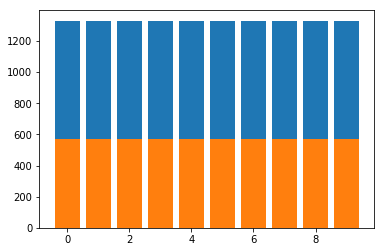

In [ ]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [ ]:
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(128, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 129, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 129, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 129, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=128,
          epochs=60,
          verbose=1,
          validation_data=(X_test, y_test))

W0805 09:28:13.819460 140313022515072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 09:28:13.919313 140313022515072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 13300 samples, validate on 5700 samples
Epoch 1/60
13300/13300 [==============================] - 69s 5ms/step - loss: 2.1799 - acc: 0.2681 - val_loss: 1.7763 - val_acc: 0.3454
Epoch 2/60
13300/13300 [==============================] - 52s 4ms/step - loss: 1.6466 - acc: 0.3996 - val_loss: 1.4039 - val_acc: 0.4954
Epoch 3/60
13300/13300 [==============================] - 53s 4ms/step - loss: 1.3512 - acc: 0.5215 - val_loss: 1.2451 - val_acc: 0.5504
Epoch 4/60
13300/13300 [==============================] - 54s 4ms/step - loss: 1.1834 - acc: 0.5869 - val_loss: 1.0228 - val_acc: 0.6381
Epoch 5/60
13300/13300 [==============================] - 54s 4ms/step - loss: 1.0570 - acc: 0.6332 - val_loss: 0.9270 - val_acc: 0.6884
Epoch 6/60
13300/13300 [==============================] - 54s 4ms/step - loss: 0.9348 - acc: 0.6796 - val_loss: 0.8956 - val_acc: 0.6928
Epoch 7/60
13300/13300 [==============================] - 54s 4ms/step - loss: 0.8691 - acc: 0.6998 - val_loss: 0.7466 - val_acc:

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

RuntimeError: ignored

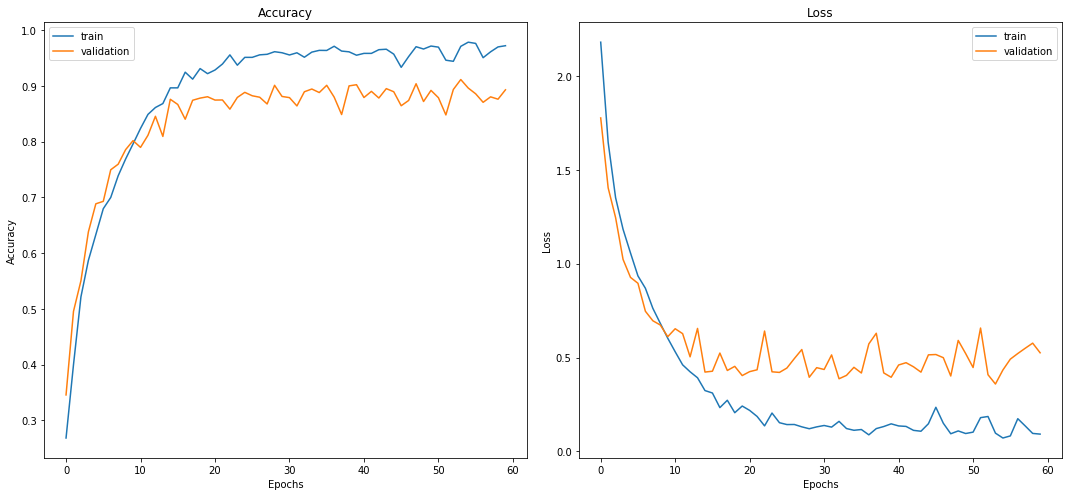

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


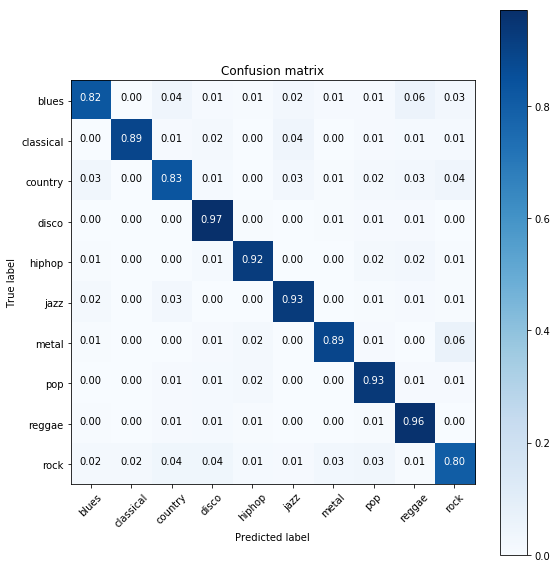

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [ ]:
# Save the model
model.save('/content/drive/My Drive/nbs_vgg16.h5')